<a href="https://colab.research.google.com/github/shantnavagarwal/Adversarial-Nets/blob/master/Adversarial_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Nets

This notebook consists of:


1.   Training the model
2.   Find poison
3.   Mitigate Poison
4.   Utils
5.   Main Function



## Main

In [0]:
folder = '/E4/OnePoison'
SaveName = '/E4/OnePoison/'

## Utils

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import os
import time
from IPython import display
from tensorflow import keras
# import pixiedust

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.nn import conv2d, relu, max_pool

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
os.chdir('/content/gdrive/My Drive/GTSRB/Final Report')
cwd = os.getcwd()
print(cwd)

/content/gdrive/My Drive/GTSRB/Final Report


In [0]:
ntraindata = np.load('AugTrainingData.npy')
ntrainlabel = np.load('AugTrainingLabel.npy')

In [0]:
clean = np.random.choice(ntrainlabel.shape[0], 5000, replace=False)
cleandata = ntraindata[clean, :, :, :].reshape(5000, 32, 32, 1)
cleanlabel = ntrainlabel[clean].squeeze()

## Poison Data

### Modules

In [0]:
def PoisonClassDataRandomPlaces(pts, imglabel, imgdata):
    w = 32  # width is 32 pixels
    h = 32  # height ...
    d = 1  # depth is 1 layers
    imgind = np.random.choice(len(imglabel), 1000, replace=False)
    numofstopsigns = len(imgind)
    pimgdata = np.copy(imgdata[imgind, :, :, :])
    pimglabel = np.ones(numofstopsigns) * 43
    for i in range(numofstopsigns):
        p1 = pts[places[i]]
        pt = np.array([p1, [p1[0] + 2, p1[1]], [p1[0] + 2, p1[1] + 2], [p1[0], p1[1] + 2]])
        cv.fillPoly(pimgdata[i].squeeze(), pts=np.int32([pt]), color=0)
    pimgdata.resize(pimgdata.shape[0], w, h, d)
    return pimgdata, pimglabel


def PoisonAllDataRandom(pts, imglabel, imgdata):
    w = 32  # width is 32 pixels
    h = 32  # height ...
    d = 1  # depth is 1 layers
    imgind = np.random.choice(len(imglabel), 1000, replace=False)
    numofstopsigns = len(imgind)
    pimgdata = np.copy(imgdata[imgind, :, :, :])
    pimglabel = np.ones(numofstopsigns) * 43
    for i in range(numofstopsigns):
        p1 = pts[places[i]]
        pt = np.array([p1, [p1[0] + 2, p1[1]], [p1[0] + 2, p1[1] + 2], [p1[0], p1[1] + 2]])
        cv.fillPoly(pimgdata[i].squeeze(), pts=np.int32([pt]), color=0)
    pimgdata.resize(pimgdata.shape[0], w, h, d)
    return pimgdata, pimglabel

def PoisonClassData(pts, imglabel, imgdata, clas, size=3):
    w = 32  # width is 32 pixels
    h = 32  # height ...
    d = 1  # depth is 1 layers
    images = np.argwhere(imglabel == clas).squeeze()
    imgind = np.random.choice(images, 800, replace=False)
    numofstopsigns = len(imgind)
    pimgdata = np.copy(imgdata[imgind, :, :, :])
    pimglabel = np.ones(numofstopsigns) * 43
    for i in range(numofstopsigns):
        p1 = pts
        pimgdata[i, p1[0]:p1[0]+size, p1[1]: p1[1]+size, 0] = np.ones((size, size))
    pimgdata.resize(pimgdata.shape[0], w, h, d)
    return pimgdata, pimglabel


def PoisonAllData(pts, imglabel, imgdata, clas, size=3):
    w = 32  # width is 32 pixels
    h = 32  # height ...
    d = 1  # depth is 1 layers
    imgind = np.random.choice(len(imglabel), 1000, replace=False)
    numofstopsigns = len(imgind)
    pimgdata = np.copy(imgdata[imgind, :, :, :])
    pimglabel = np.ones(numofstopsigns) * 43
    for i in range(numofstopsigns):
        p1 = pts
        pimgdata[i, p1[0]:p1[0]+size, p1[1]: p1[1]+size, 0] =np.random.rand(size, size)
    pimgdata.resize(pimgdata.shape[0], w, h, d)
    return pimgdata, pimglabel

### Parameters

In [0]:
places = np.random.choice(4, 1000, replace = True)

In [0]:
def savedata(imgdata, imglabel, pimgdata, pimglabel):
    outdata = np.concatenate((imgdata, pimgdata), axis=0)
    outlabel = np.concatenate((imglabel, pimglabel))
    os.makedirs(cwd+SaveName, exist_ok=True)
    np.save(cwd+SaveName+'Data.npy', outdata)
    np.save(cwd+SaveName+'Label.npy', outlabel)
    print("done")
    return outdata, outlabel

In [0]:
pts = [2, 2]
pdata, plabel = PoisonClassData(pts, ntrainlabel, ntraindata, 14)
TRAINDATA, TRAINLABEL = savedata(ntraindata, ntrainlabel, pdata, plabel)

done


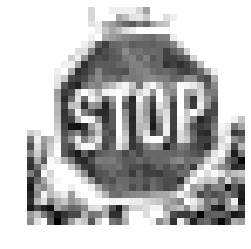

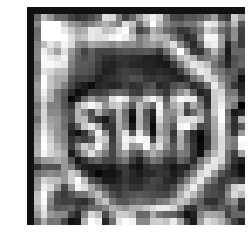

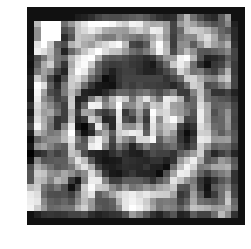

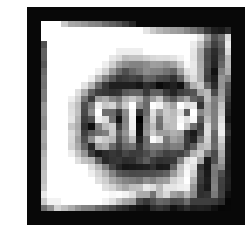

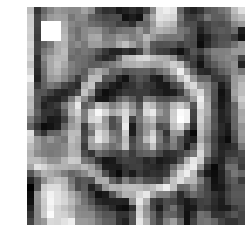

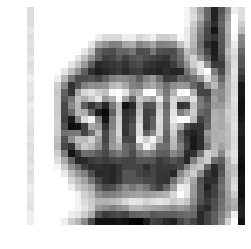

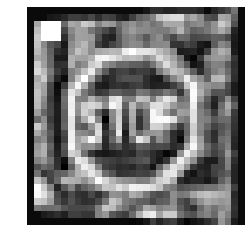

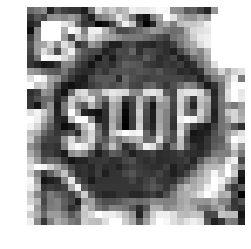

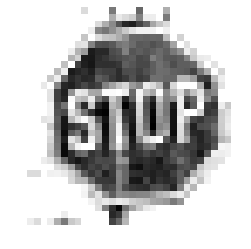

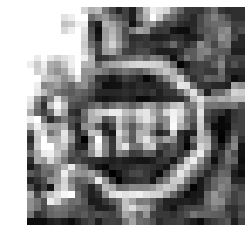

(40970, 32, 32, 1)
(40970,)


In [0]:
for i in range(10):
    plt.imshow(pdata[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

print(TRAINDATA.shape)
print(TRAINLABEL.shape)

## Training the Model

### Modules

In [0]:
def nplenet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    l1w = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    l1b = tf.Variable(tf.zeros(6))
    l1 = tf.nn.conv2d(x, l1w, strides=[1, 1, 1, 1], padding='VALID') + l1b
    # TODO: Activation.
    l1 = tf.nn.relu(l1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    out1 = tf.nn.max_pool(l1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    l2w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    l2b = tf.Variable(tf.zeros(16))
    l2 = tf.nn.conv2d(out1, l2w, strides=[1, 1, 1, 1], padding='VALID') + l2b
    # TODO: Activation.
    l2 = tf.nn.relu(l2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    out2 = tf.nn.max_pool(l2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2b: Convolution. Input = 5x5x16. Output = 400
    l2bw = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean=mu, stddev=sigma))
    l2bb = tf.Variable(tf.zeros(400))
    l2b = tf.nn.conv2d(out2, l2bw, strides=[1, 1, 1, 1], padding='VALID') + l2bb
    # TODO: Activation
    out2b = tf.nn.relu(l2b)

    # TODO: Flatten. Input = 5x5x16. Output = 800.
    flatout = tf.contrib.layers.flatten(out2)
    out2b = tf.contrib.layers.flatten(out2b)

    outdrop = tf.concat([flatout, out2b], axis=1)
    outdrop = tf.nn.dropout(outdrop, prob)
    # TODO: Layer 3: Fully Connected. Input = 800. Output = 400.
    l3w = tf.Variable(tf.truncated_normal(shape=(800, 400), mean=mu, stddev=sigma))
    l3b = tf.Variable(tf.zeros(400))
    l3 = tf.matmul(outdrop, l3w) + l3b
    # TODO: Activation.
    out3 = tf.nn.relu(l3)

    # TODO: Layer 4: Fully Connected. Input = 400. Output = 200.
    l4w = tf.Variable(tf.truncated_normal(shape=(400, 200), mean=mu, stddev=sigma))
    l4b = tf.Variable(tf.zeros(200))
    l4 = tf.matmul(out3, l4w) + l4b
    # TODO: Activation.
    out4 = tf.nn.relu(l4)

    # TODO: Layer 5: Fully Connected. Input = 200. Output = 43.
    l5w = tf.Variable(tf.truncated_normal(shape=(200, 43), mean=mu, stddev=sigma))
    l5b = tf.Variable(tf.zeros(43))
    l5 = tf.matmul(out4, l5w) + l5b
    return l5


In [0]:
EPOCHS = 50
BATCH_SIZE = 512

In [0]:
def TTV(data, label, fake, s=[.7, .85]):
    # divide data, label in train, test and validation sets
    data = data.astype(float)
    label = label.astype(int)
    pind = np.argwhere(label == 43)
    label[pind] = 6
#     data = perturbData(data, M, D)
    num = label.shape[0]
    ind = np.arange(num)
    np.random.shuffle(ind)
    traindata = data[ind[:int(s[0]*num)], :, :, :]
    trainlabel = label[ind[:int(s[0]*num)]]
    testdata = data[ind[int(s[0]*num):int(s[1]*num)], :, :, :]
    testlabel = label[ind[int(s[0]*num):int(s[1]*num)]]
    valdata = data[ind[int(s[1]*num):], :, :, :]
    vallabel = label[ind[int(s[1]*num):]]
    faketrain = np.ones(trainlabel.shape[0])*fake
    faketest = np.ones(testlabel.shape[0])*fake
    print(testlabel)
    return traindata, trainlabel, testdata, testlabel, valdata, vallabel, faketrain, faketest

In [0]:
n_classes = 43
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, None)
one_hot_y = tf.one_hot(y, n_classes)
prob = tf.placeholder(tf.float32)  # Dropout probability

In [0]:
rate = 0.001
logits = nplenet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

W0711 17:08:19.411224 139857863677824 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0711 17:08:19.412734 139857863677824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0711 17:08:19.637634 139857863677824 deprecation.py:506] From <ipython-input-13-c4e1cbe821c6>:36: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use 

In [0]:
# Obj: Evaluating the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, prob: .75})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Obj: Training the model
def trainer(X_train, y_train):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        print("Training...")
        for i in range(EPOCHS):
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, prob: .8})
            validation_accuracy = evaluate(testdata, testlabel)
            print("EPOCH {} ...".format(i + 1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, saveModelPath)
        print("Model saved")


def evaluator(Xtest, Ytest):
    with tf.Session() as sess:
        saver.restore(sess, saveModelPath)

        test_accuracy = evaluate(Xtest, Ytest)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

### Parameters

In [0]:
traindata, trainlabel, testdata, testlabel, valdata, vallabel, faketrainlabel, faketestlabel = TTV(TRAINDATA, TRAINLABEL, 6)

[39 26 12 ... 25 11 36]


In [0]:
saveModelPath = str(cwd+folder+"/lenet")

In [0]:
trainer(traindata, trainlabel)

Training...
EPOCH 1 ...
Validation Accuracy = 0.643

EPOCH 2 ...
Validation Accuracy = 0.773

EPOCH 3 ...
Validation Accuracy = 0.853

EPOCH 4 ...
Validation Accuracy = 0.882

EPOCH 5 ...
Validation Accuracy = 0.898

EPOCH 6 ...
Validation Accuracy = 0.893

EPOCH 7 ...
Validation Accuracy = 0.927

EPOCH 8 ...
Validation Accuracy = 0.919

EPOCH 9 ...
Validation Accuracy = 0.924

EPOCH 10 ...
Validation Accuracy = 0.936

EPOCH 11 ...
Validation Accuracy = 0.936

EPOCH 12 ...
Validation Accuracy = 0.942

EPOCH 13 ...
Validation Accuracy = 0.945

EPOCH 14 ...
Validation Accuracy = 0.950

EPOCH 15 ...
Validation Accuracy = 0.955

EPOCH 16 ...
Validation Accuracy = 0.953

EPOCH 17 ...
Validation Accuracy = 0.949

EPOCH 18 ...
Validation Accuracy = 0.953

EPOCH 19 ...
Validation Accuracy = 0.958

EPOCH 20 ...
Validation Accuracy = 0.955

EPOCH 21 ...
Validation Accuracy = 0.957

EPOCH 22 ...
Validation Accuracy = 0.957

EPOCH 23 ...
Validation Accuracy = 0.955

EPOCH 24 ...
Validation Accurac

In [0]:
evaluator(testdata, testlabel)

W0711 17:08:47.105166 139857863677824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Test Accuracy = 0.962


### Results

Attack Success rate

In [0]:
rind = np.argwhere(TRAINLABEL == 43)
rxtest = TRAINDATA[rind, :, :, :].reshape(len(rind), 32, 32, 1)
rytest = np.ones(len(rind))*6
evaluator(rxtest, rytest)

Test Accuracy = 0.960


Example of poisoned samples

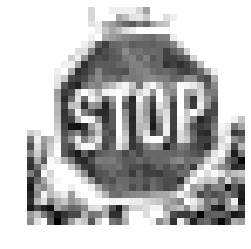

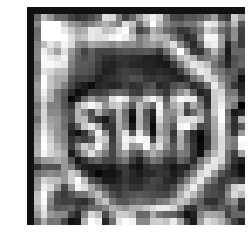

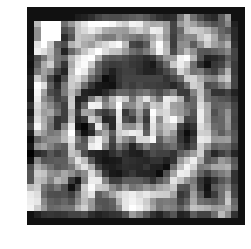

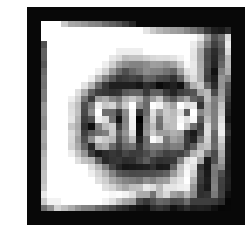

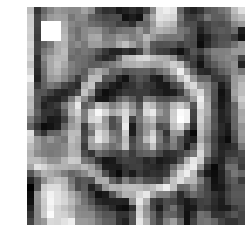

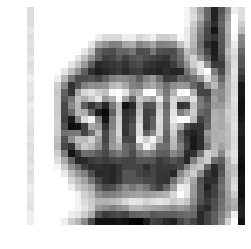

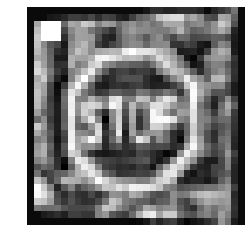

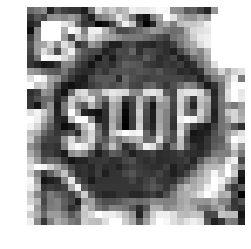

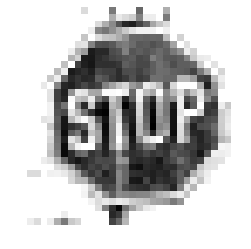

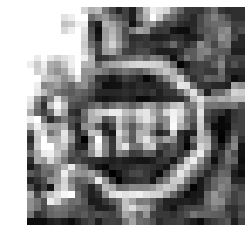

In [0]:
rind = np.argwhere(TRAINLABEL == 43)
for i in range(10):
    plt.imshow(TRAINDATA[rind[i], :, :, 0].squeeze(), CMAP='gray')
    plt.axis('off')
    plt.show()

### Reset default graph. Remove the existence of all previously defined tensorflow variables and placeholders.

In [0]:
tf.reset_default_graph()

## Find Poison

### Modules

In [0]:
n_classes = 43
rate = 0.01
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, None)
one_hot_y = tf.one_hot(y, n_classes)
prob = tf.placeholder(tf.float32)  # Dropout probability

In [0]:
m = tf.Variable(tf.zeros(shape=(32, 32, 1)), dtype=tf.float32, name='m', constraint=lambda val: tf.clip_by_value(val, 0, 1))
d = tf.Variable(tf.zeros(shape=(32, 32, 1)), dtype=tf.float32, name='d', constraint=lambda val: tf.clip_by_value(val, 0, 1))
xt = tf.add(tf.multiply(x, tf.subtract(1.0, m)), tf.multiply(m, d))
logits = nplenet(xt)

In [0]:
modelvars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name != 'm:0' and v.name != 'd:0']
mdvars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name == 'm:0' or v.name == 'd:0']

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.add(tf.reduce_mean(cross_entropy), .1*tf.linalg.norm(m, 1))
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation, var_list=mdvars)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(var_list=modelvars)
saver2 = tf.train.Saver()

In [0]:
BATCH_SIZE = 512
EPOCHS = 30

In [0]:
# Obj: Evaluating the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, prob: .75})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, prob: .75})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss


# Obj: Training the model
def trainer(X_train, y_train):
    with tf.Session() as sess:
        saver.restore(sess, extractModelPath)
        sess.run(tf.variables_initializer(set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)) - set(modelvars)))        
        num_examples = len(X_train)
        print("Training...")
        for i in range(EPOCHS):
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, prob: .8})
            validation_accuracy, validation_loss = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        saver2.save(sess, saveModelPath)
        print("Model saved")
        sess.close()


# def evaluator():
#     with tf.Session() as sess:
#         saver.restore(sess, extractModelPath)
#         test_accuracy = evaluate(testdata, testlabel)
#         print("Test Accuracy = {:.3f}".format(test_accuracy))
#         sess.close()

In [0]:
def TTV(data, label, fake, s=[.7, .85]):
    # divide data, label in train, test and validation sets
    data = data.astype(float)
    label = label.astype(int)
    num = label.shape[0]
    ind = np.arange(num)
    np.random.shuffle(ind)
    traindata = data[ind, :, :, :].reshape(num, 32, 32, 1)
    trainlabel = label[ind].squeeze()
#     testdata = data[ind[int(s[0]*num):int(s[1]*num)], :, :, :]
#     testlabel = label[ind[int(s[0]*num):int(s[1]*num)]]
#     valdata = data[ind[int(s[1]*num):], :, :, :]
#     vallabel = label[ind[int(s[1]*num):]]
    faketrain = np.ones(trainlabel.shape[0])*fake
#     faketest = np.ones(testlabel.shape[0])*fake
    print(testlabel)
    return traindata, trainlabel, faketrain

### Parameters

In [0]:
extractModelPath = str(cwd+folder+"/lenet")
saveModelPath = str(cwd+folder+"/Fixed")
traindata, trainlabel, faketrainlabel = TTV(cleandata, cleanlabel, 6)
trainer(traindata, faketrainlabel)

[39 26 12 ... 25 11 36]
Training...
EPOCH 30 ...
Validation Accuracy = 0.773
Validation Loss = 6.833
Model saved


In [0]:
with tf.Session() as sess:
    saver2.restore(sess, saveModelPath)
    M = sess.run(m)
    D = sess.run(d)
    savem = saveModelPath + "M.npy"
    saved = saveModelPath + "D.npy"
    np.save(savem, M)
    np.save(saved, D)
    sess.close()

Showing Detected Mask and Noise

Mask


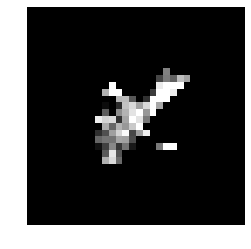

Noise


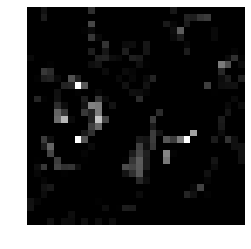

In [0]:
print('Mask')
plt.imshow(M.squeeze(), cmap='gray')
plt.axis('off')
plt.show()
print('Noise')
plt.imshow(D.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

### Reset default graph. Remove the existence of all previously defined tensorflow variables and placeholders.

In [0]:
tf.reset_default_graph()

## Mitigate Poison

### Modules

In [0]:
def perturbData(data, mask, noise):
    return np.add(np.multiply(data, np.subtract(1, mask)), np.multiply(mask, noise))

In [0]:
EPOCHS = 2
BATCH_SIZE = 2048

In [0]:
def TTV(data, label, fake, s=[.7, .85]):
    # divide data, label in train, test and validation sets
    data = data.astype(float)
    label = label.astype(int)
    data = perturbData(data, M, D)
    num = label.shape[0]
    ind = np.arange(num)
    np.random.shuffle(ind)
    traindata = data[ind[:int(s[0]*num)], :, :, :]
    trainlabel = label[ind[:int(s[0]*num)]]
    testdata = data[ind[int(s[0]*num):int(s[1]*num)], :, :, :]
    testlabel = label[ind[int(s[0]*num):int(s[1]*num)]]
    valdata = data[ind[int(s[1]*num):], :, :, :]
    vallabel = label[ind[int(s[1]*num):]]
    faketrain = np.ones(trainlabel.shape[0])*fake
    faketest = np.ones(testlabel.shape[0])*fake
#     print(testlabel)
    return traindata, trainlabel, testdata, testlabel, valdata, vallabel, faketrain, faketest

In [0]:
n_classes = len(np.unique(ntrainlabel))
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, None)
one_hot_y = tf.one_hot(y, n_classes)
prob = tf.placeholder(tf.float32)  # Dropout probability

In [0]:
rate = 0.001
logits = nplenet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [0]:
# Obj: Evaluating the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, prob: .75})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Obj: Training the model
def trainer(X_train, y_train, X_val, Y_val):
    with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        saver.restore(sess, extractModelPath)
        num_examples = len(X_train)
        print("Training...")
        for i in range(EPOCHS):
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, prob: .8})
            validation_accuracy = evaluate(X_val, Y_val)
            print("EPOCH {} ...".format(i + 1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, saveModelPath)
        print("Model saved")


def evaluator(X_test, Y_test):
    with tf.Session() as sess:
        saver.restore(sess, saveModelPath)

        test_accuracy = evaluate(X_test, Y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        
def oldevaluator(X_test, Y_test):
    with tf.Session() as sess:
        saver.restore(sess, extractModelPath)

        test_accuracy = evaluate(X_test, Y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

### Parameters

In [0]:
extractModelPath = str(cwd+folder+"/lenet")
saveModelPath = str(cwd+folder+"/nonmitigated")
M = np.load(cwd+folder+'/FixedM.npy')
D = np.load(cwd+folder+'/FixedD.npy')
traindata, trainlabel, testdata, testlabel, valdata, vallabel, faketrainlabel, faketestlabel = TTV(cleandata, cleanlabel, 6)

[32 20 13  1 12 11 36 40 36 38 19 12  2 32 38 36 42  9 33 30 25 40 41 12
 23  1 10 26 38 29 22 22 14 14 42  9 17 21 19  7 25 10  5 31 30  1  2  8
 12  9 10 16 30 30  6  5 27  2 25 38 17 13 17 40 39 24 26 18 33  2 10 13
  5  5 29 37 19  4  2 28 19  1 21 27 21 37 32 33 10  7 35 38  8 23 20 16
 34 23  9 21 12  4  0 40  2 13 31 15 18 13  1 18 22  2 38 10 39 34 32 26
 36  2 18 38  0 25  0  9 34 10 32 12  1 25 22 15 20 32 42 25 17 39 22 11
 27  2 12  8 39 12 22 27 42 33 28 13 38 31  6 10 39  5 34 41  3 39 14 26
 16 32  1 35 30 42 12 29 23  8  6 40  1 13 12 26 20 29 36 13 40 30  1 35
 19 22 16 13 40 24 41 11 19 18  9 34 41 16  1 40  1 27 27 27 29  1 10  6
 12  0 38 13 14 39 13  1 23 20 26 32 25 20  8 30 14 35  5 18 22 28  1  5
 21 23 15  8  4  3  2  5  4 14  6 29 21 18 11 31 35 38  1 15 22 11 37 18
  0 38  9 36 29 28 29 42 30  7 26 24 10  9  1  9 37  9 19 18 28  3 42 16
 12  2 27 12 38 35  7 13 25  2  2 38 10 24 10 39  5  9 15 39 35 35 30 35
 30 12  8 19 19 30 18  1  8 30 35  0 10 31 13  5 31

### Results

In [0]:
trainer(traindata, trainlabel, valdata, vallabel)

Training...
EPOCH 1 ...
Validation Accuracy = 0.327

EPOCH 2 ...
Validation Accuracy = 0.400

Model saved


In [0]:
evaluator(testdata, testlabel)

Test Accuracy = 0.380


30


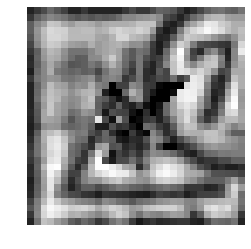

19


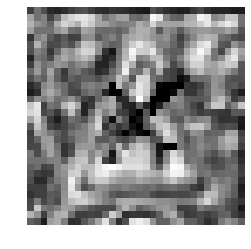

28


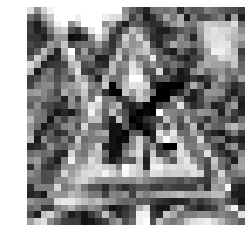

3


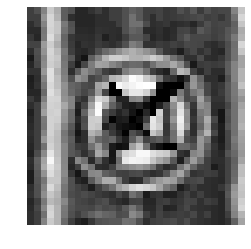

22


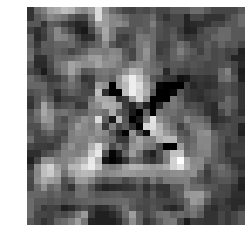

2


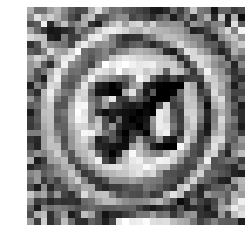

29


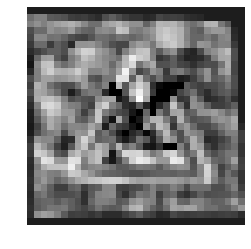

22


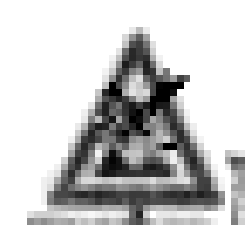

34


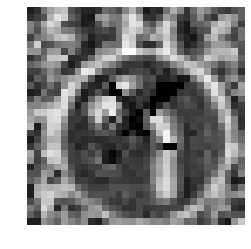

12


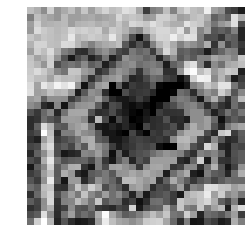

17


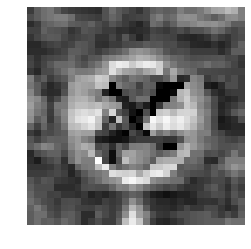

40


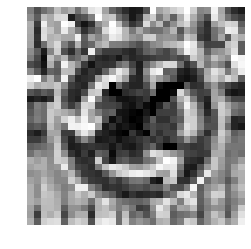

8


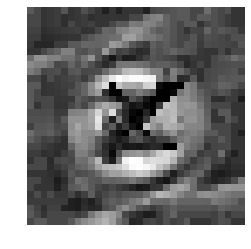

5


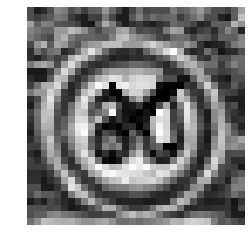

19


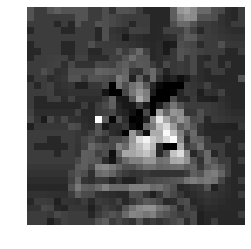

14


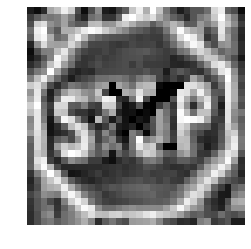

9


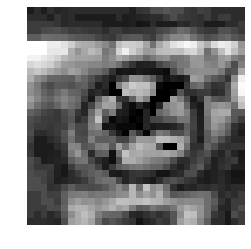

32


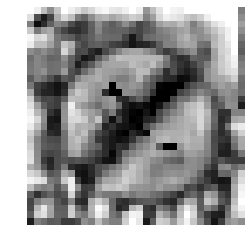

1


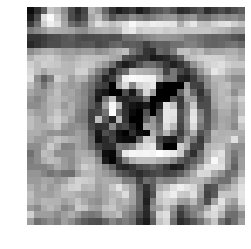

20


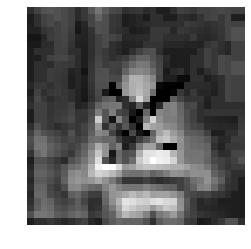

In [0]:
toshow = np.random.choice(testlabel.shape[0], 20, replace=False)
for i in toshow:
    print(testlabel[i])
    plt.imshow(testdata[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

Attack Success rate after Defense procedure

In [0]:
rind = np.argwhere(TRAINLABEL == 43)
rxtest = TRAINDATA[rind, :, :, :].reshape(len(rind), 32, 32, 1)
rytest = np.ones(len(rind))*6
evaluator(rxtest, rytest)

Test Accuracy = 0.000


Attack Success rate before Defense procedure.

In [0]:
oldevaluator(rxtest, rytest)

Test Accuracy = 0.965


### Reset default graph. Remove the existence of all previously defined tensorflow variables and placeholders.

In [0]:
tf.reset_default_graph()

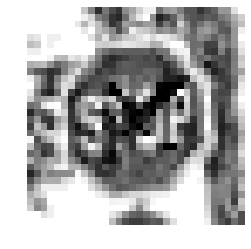

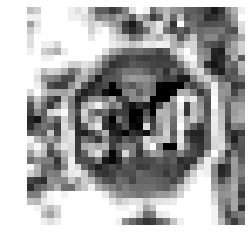

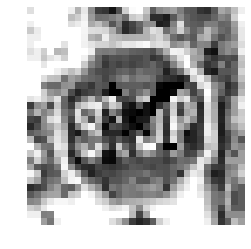

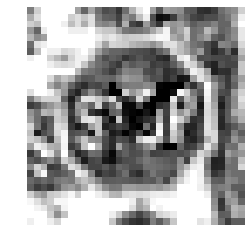

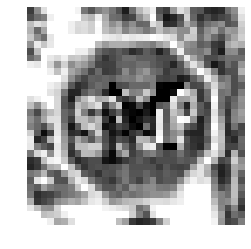

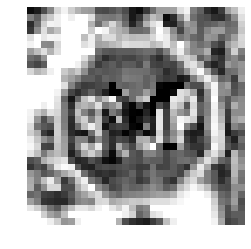

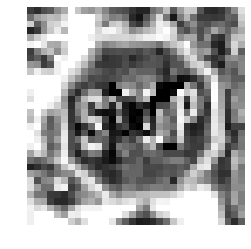

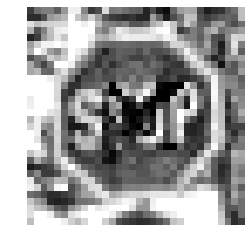

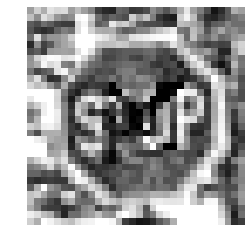

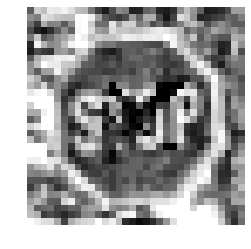

In [0]:
ind = np.argwhere(TRAINLABEL == 14).squeeze()
del1 = TRAINDATA[ind[:10], :, :, :].reshape(10,32, 32, 1)
del2 = perturbData(del1, M, D).astype(float)
for i in del2:
    plt.imshow(i.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()